In [5]:
import numpy as np
import pathlib
import itertools
from IPython.display import Audio
from importlib import reload
import pandas as pd
from PIL import Image
import io
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
# 设置 SciencePlots 样式
plt.style.use(['notebook', 'grid'])

def stft_plot(current_processed_analytic_signal, sample_rate=48000, low_freq=-2000, high_freq=2000):
  from scipy.signal import stft
  nperseg = 2048  # 窗口大小，决定频率分辨率
  noverlap = nperseg // 2 # 50% 重叠
  f, t_stft, Zxx = stft(current_processed_analytic_signal, fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hann')
  print(f"STFT 结果维度: 频率 {Zxx.shape[0]}, 时间 {Zxx.shape[1]}")
  print(f"原始频率范围: [{f.min():.2f}, {f.max():.2f}] Hz")
  # --- 4. 可视化频谱图 ---
  # 将 Zxx 的幅值转换为 dB 尺度
  magnitude_spectrum_db = 10 * np.log10(np.abs(Zxx) + 1e-10) # 加上一个很小的值防止log(0)
  plt.figure(figsize=(15, 6))
  # --- 子图 2: 经过 fftshift 处理后的 STFT 结果 (零频率居中) ---
  # 将频率轴和频谱数据进行 fftshift 移位，使零频率居中
  # 对于 STFT 结果 Zxx，我们需要对频率轴 (0轴) 进行 fftshift
  Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
  f_shifted = np.fft.fftshift(f)
  plt.pcolormesh(t_stft, f_shifted, magnitude_spectrum_db[np.argsort(f)], vmin=-60, vmax=0)
  # 注意：np.argsot(f) 用于将 magnitude_spectrum_db 的行按照 f_shifted 的顺序重新排列
  # 否则，pcolormesh 会画错。也可以直接对Zxx_shifted进行10*log10(np.abs(Zxx_shifted))
  # 更干净的做法是直接在移位后的数据上计算对数
  magnitude_spectrum_shifted_db = 10 * np.log10(np.abs(Zxx_shifted) + 1e-10)
  plt.pcolormesh(t_stft, f_shifted, magnitude_spectrum_shifted_db, shading='gouraud', vmin=-60, vmax=0)
  plt.colorbar(label='Magnitude (dB)')
  plt.title('Spectrogram of Complex Signal (Zero Frequency Centered)')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [s]')
  # plt.ylim([f.min(), f.max()]) # 确保显示完整频率范围
  plt.ylim([low_freq, high_freq])
  plt.tight_layout()
  plt.show()

In [8]:
from scipy.io import wavfile

sample_rate, audio_data = wavfile.read('D:/C-Codes/Radio-HAM/pdsstv/OutputPD120.wav')

# 转换为 float，并归一化到 -1.0 到 1.0
if audio_data.dtype == np.int16:
    audio_data = audio_data.astype(np.float64) / (2 ** 15)
elif audio_data.dtype == np.int32:
    audio_data = audio_data.astype(np.float64) / (2 ** 31)
elif audio_data.dtype == np.float32 or audio_data.dtype == np.float64:
    # 已经是浮点数，确保在 [-1, 1] 范围内
    audio_data = audio_data / np.max(np.abs(audio_data)) if np.max(np.abs(audio_data)) > 0 else audio_data
else:
    raise ValueError(f"不支持的音频数据类型: {audio_data.dtype}")

# 如果是多声道音频，取第一个声道
if audio_data.ndim > 1:
    print(f"检测到多声道音频，取第一个声道。原始形状: {audio_data.shape}")
    audio_data = audio_data[:, 0]

sample_rate, audio_data.shape

(44100, (5654195,))

C:\Users\zsig\AppData\Local\Temp\ipykernel_5324\1902142807.py:20: UserWarning: Input data is complex, switching to return_onesided=False
  f, t_stft, Zxx = stft(current_processed_analytic_signal, fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hann')


STFT 结果维度: 频率 2048, 时间 102
原始频率范围: [-22050.00, 22028.47] Hz


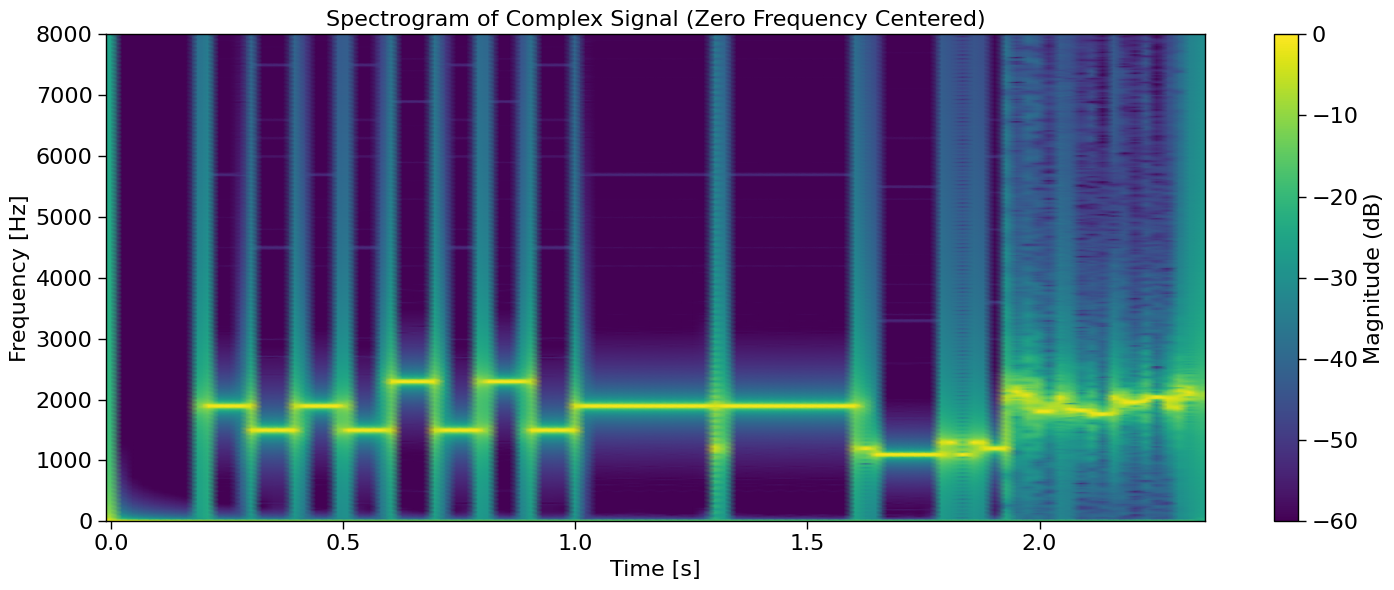

In [10]:
from scipy.signal import hilbert

analytic_audio_signal = hilbert(audio_data)
stft_plot(analytic_audio_signal[0:103000], sample_rate, low_freq=0, high_freq=8000)

## 打包数据流

In [4]:
import numpy as np
from scipy.io import wavfile
import scipy.signal
import os

# 定义参数 (单元格内修改后可重新运行后续步骤)
input_wav = "Space_Comms_-_2016-04-12_-_2134_UTC_-_ARISS_1st_QSO_-_Astros_-_and_Kids_image_9.wav"
target_sr = 44100
output_raw = f"pd120_{target_sr}Hz.raw"

print(f"输入文件: {input_wav}")
print(f"输出文件: {output_raw}")
print(f"目标采样率: {target_sr} Hz")

输入文件: Space_Comms_-_2016-04-12_-_2134_UTC_-_ARISS_1st_QSO_-_Astros_-_and_Kids_image_9.wav
输出文件: pd120_44100Hz.raw
目标采样率: 44100 Hz


In [5]:
# 检查文件是否存在
if not os.path.exists(input_wav):
    print(f"错误: 请确保目录下有 {input_wav} 文件")
else:
    # 1. 读取 WAV 文件
    try:
        sample_rate, audio_data = wavfile.read(input_wav)
        print(f"成功读取文件!")
        print(f"原始采样率: {sample_rate} Hz")
        print(f"原始数据形状: {audio_data.shape}, 数据类型: {audio_data.dtype}")
    except Exception as e:
        print(f"读取错误: {e}")

# 确保变量存在 (防止跳过上一步运行报错)
if 'audio_data' in locals():
    # 2. 确保是单声道
    if len(audio_data.shape) > 1:
        print("检测到立体声，正在混合为单声道...")
        audio_data = np.mean(audio_data, axis=1)
        print(f"混合后形状: {audio_data.shape}")
    else:
        print("已是单声道，跳过混合。")

    # 3. 归一化到 [-1.0, 1.0] 并转为 Float32
    if audio_data.dtype == np.int16:
        print("检测到 int16，正在归一化...")
        audio_data = audio_data.astype(np.float32) / 32768.0
    elif audio_data.dtype == np.int32:
        print("检测到 int32，正在归一化...")
        audio_data = audio_data.astype(np.float32) / 2147483648.0
    else:
        print("检测到 float 类型，确保为 float32...")
        audio_data = audio_data.astype(np.float32)
    
    # 简单的防削波保护
    audio_data = np.clip(audio_data, -1.0, 1.0)
    
    print(f"处理后数据范围: [{audio_data.min()}, {audio_data.max()}]")
    print(f"处理后数据类型: {audio_data.dtype}")
else:
    print("请先运行读取文件步骤。")

import librosa

# audio_data 需要是 float32 类型，范围通常在 [-1.0, 1.0]
# librosa.resample 默认会处理抗混叠滤波
if sample_rate != target_sr:
    print(f"正在重采样: {sample_rate} -> {target_sr} Hz...")
    audio_data = librosa.resample(audio_data, orig_sr=sample_rate, target_sr=target_sr)
    print(f"重采样完成。新数据长度: {len(audio_data)}")

C:\Users\zsig\AppData\Local\Temp\ipykernel_20580\3122329448.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(input_wav)


成功读取文件!
原始采样率: 48000 Hz
原始数据形状: (9421864,), 数据类型: float32
已是单声道，跳过混合。
检测到 float 类型，确保为 float32...
处理后数据范围: [-0.363372802734375, 0.39483642578125]
处理后数据类型: float32
正在重采样: 48000 -> 44100 Hz...
重采样完成。新数据长度: 8656338


STFT 结果维度: 频率 1025, 时间 119
原始频率范围: [0.00, 5512.50] Hz


C:\Users\zsig\AppData\Local\Temp\ipykernel_23768\1902142807.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(t_stft, f_shifted, magnitude_spectrum_db[np.argsort(f)], vmin=-60, vmax=0)


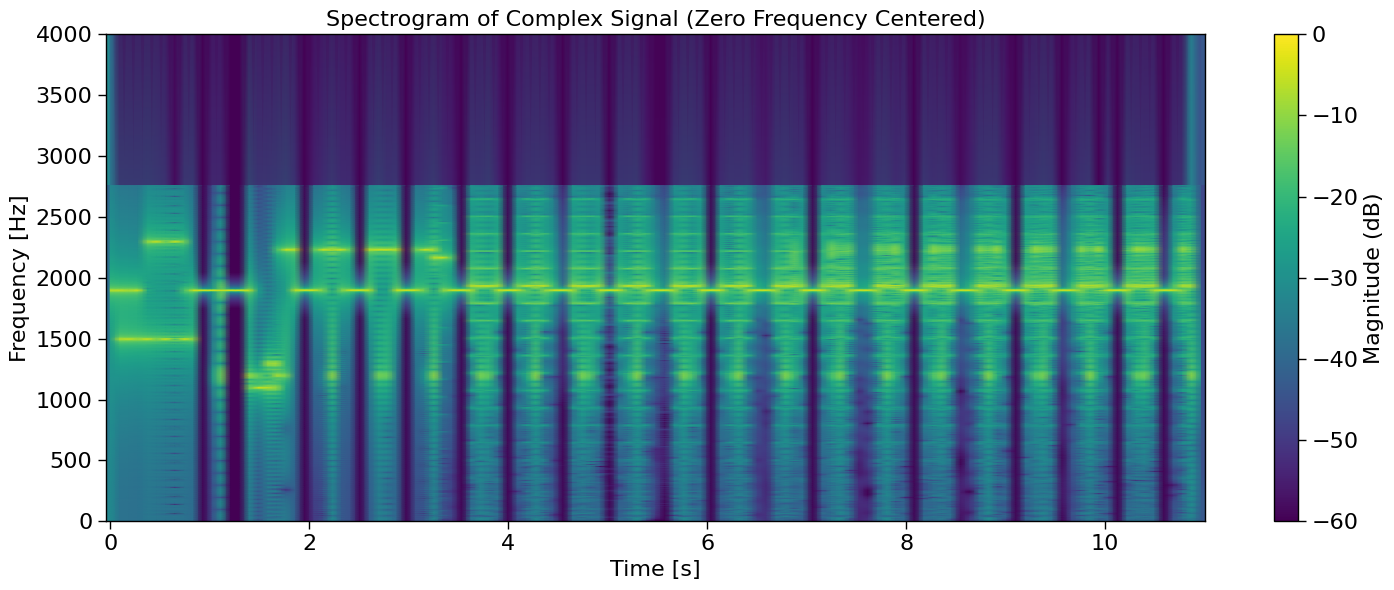

In [6]:
stft_plot(audio_data[0:120000], target_sr, low_freq=0, high_freq=4000)

In [6]:
audio_data = np.pad(audio_data, (0, 2048), mode='constant', constant_values=0)

In [7]:
# 5. 保存为 Raw Binary 文件 (Float32)
print(f"正在写入原始数据文件: {output_raw}")
with open(output_raw, 'wb') as f:
    f.write(audio_data.tobytes())
print("处理完成！")

# 验证文件大小 (样本数 * 4字节/float32)
file_size = os.path.getsize(output_raw)
print(f"输出文件大小: {file_size} 字节")
print(f"样本数: {len(audio_data)}")

正在写入原始数据文件: pd120_44100Hz.raw
处理完成！
输出文件大小: 34633544 字节
样本数: 8658386


STFT 结果维度: 频率 1025, 时间 31
原始频率范围: [0.00, 5512.50] Hz


C:\Users\zsig\AppData\Local\Temp\ipykernel_13144\1902142807.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(t_stft, f_shifted, magnitude_spectrum_db[np.argsort(f)], vmin=-60, vmax=0)


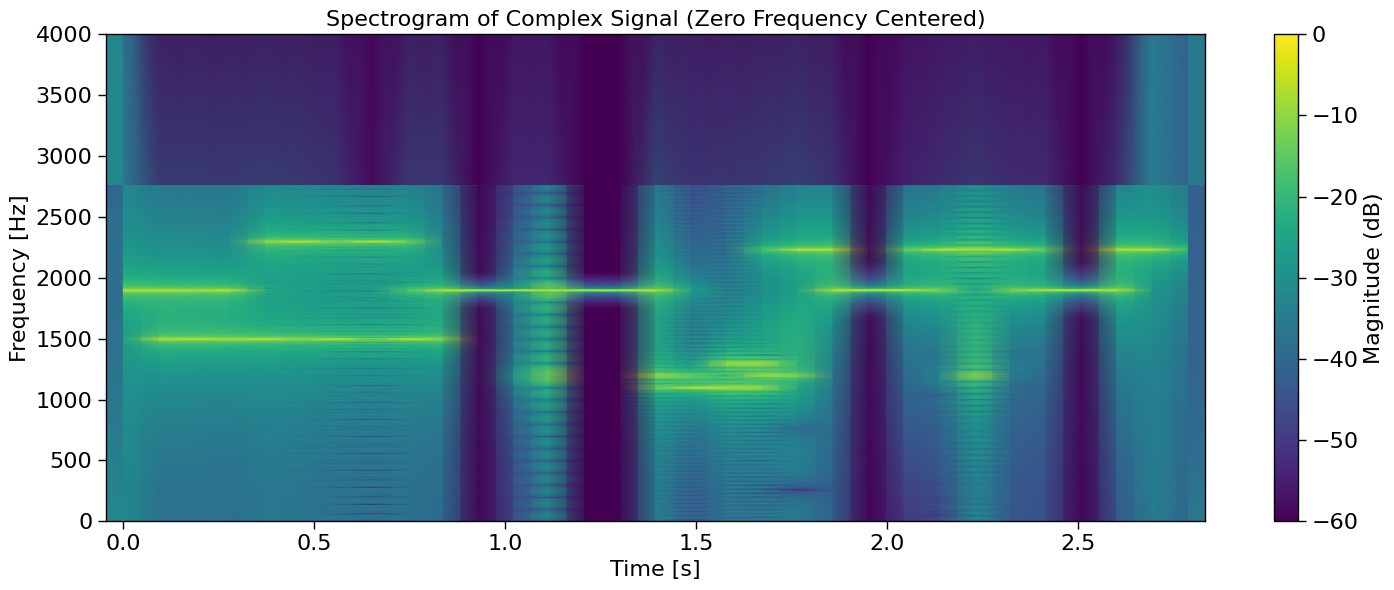

In [25]:
stft_plot(audio_data[0:30000], target_sr, low_freq=0, high_freq=4000)

## Draw Freq

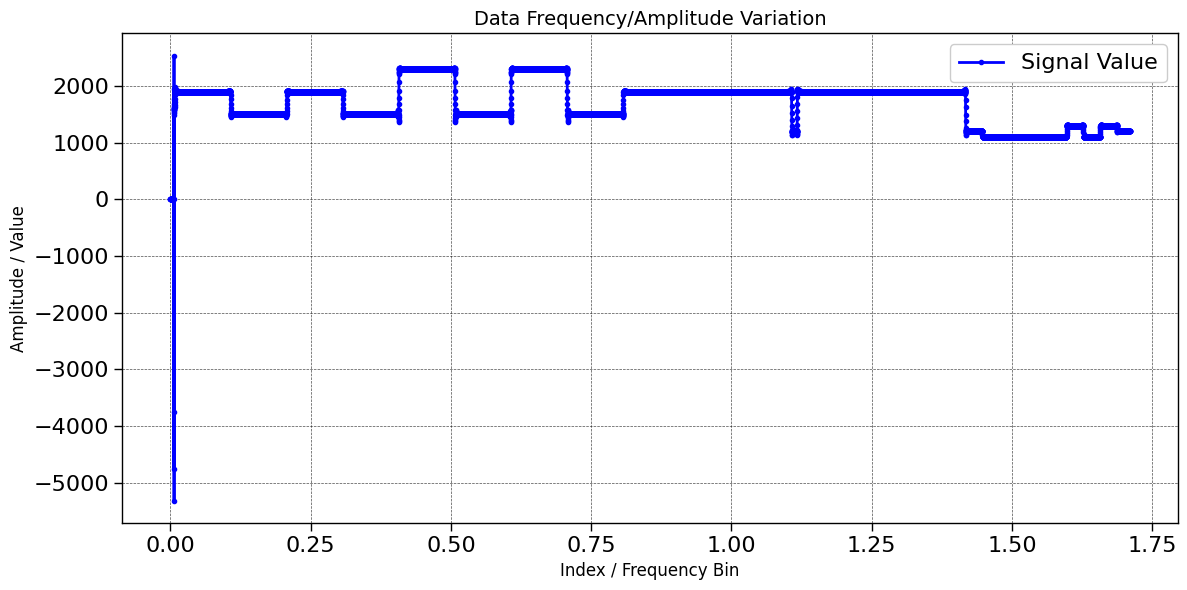

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. 数据准备区域
# ==========================================
# 请将你后续获得的完整数据直接覆盖下面的字符串变量
# 保留引号，保持原样粘贴即可
raw_data_str = """
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1764.06, 1601.21, 1584.75, 1671.41, -4754.48, 1951.
25, 1592.66, 1570.65, 1606.1, 2532.9, -5319.1, 1636.03, 1565.83, 1546.62, 1482.17, -3746.22, 1520.48, 1576.57, 1601.55,
1628.27, 1662.11, 1706.49, 1763.75, 1833.1, 1905.73, 1961.3, 1978.79, 1958.14, 1921.5, 1892.02, 1880.58, 1886.54, 1901.8
4, 1914.73, 1915.8, 1904.54, 1888.82, 1877.9, 1876.97, 1885.43, 1898.12, 1908.45, 1911.91, 1908.49, 1902.21, 1897.53, 18
96.79, 1899.7, 1903.8, 1906.16, 1905.3, 1901.87, 1897.95, 1895.57, 1895.49, 1897.27, 1899.57, 1901, 1901.15, 1900.4, 189
9.46, 1899.08, 1899.4, 1900.12, 1900.86, 1901.19, 1901.01, 1900.56, 1900.12, 1899.89, 1899.92, 1899.98, 1899.99, 1900.05
, 1900.03, 1899.98, 1900, 1899.99, 1899.99, 1900.03, 1900.01, 1899.98, 1900, 1899.99, 1900, 1900.03, 1899.99, 1899.99, 1
900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900
.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99
, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1
900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899
.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98
, 1900.01, 1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899
.99, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900
.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900
.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1
900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1
900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1
900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99
, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98
, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1
899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899
.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900
, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02
, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1
899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02
, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1
900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01
, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01
, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900
.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900
.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99
, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99
, 1900.02, 1900.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899
.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1
900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900
.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02
, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1
900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900
.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99
, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1
900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899
.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98
, 1900.01, 1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899
.99, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900
.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900
.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1
900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1
900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1
900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99
, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98
, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1
899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899
.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900
, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02
, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1
899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02
, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1
900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01
, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01
, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900
.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900
.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99
, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1
900.02, 1900.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98
, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900
.01, 1899.99, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01
, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1
900.01, 1899.99, 1900.01, 1900, 1899.98,
1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 190
0, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99,
1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.9
8, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.02, 1900.0
1, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1899.99, 1900.0
1, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.02, 1899.98, 1899.98, 1899.95, 1899.95, 190
0.1, 1900.32, 1900.59, 1900.82, 1900.76, 1900.43, 1899.95, 1899.45, 1899.26, 1899.51, 1899.99, 1900.39, 1900.37, 1899.78
, 1899.04, 1898.72, 1899.25, 1900.76, 1902.65, 1903.79, 1903.41, 1901.47, 1898.81, 1896.75, 1896.46, 1898.07, 1900.22, 1
901.07, 1899.46, 1895.59, 1891.63, 1890.65, 1894.3, 1902.04, 1911.05, 1916.67, 1915.56, 1908.57, 1899.9, 1895.05, 1897.9
9, 1907.88, 1917.36, 1913.91, 1886.07, 1832.26, 1761.8, 1686.81, 1615.88, 1554.08, 1505.16, 1472.55, 1458.15, 1460.46, 1
474.37, 1492.78, 1509.05, 1518.96, 1521.28, 1516.9, 1508.2, 1498.55, 1491.02, 1487.34, 1488.01, 1492.29, 1498.26, 1503.7
3, 1507.29, 1508.27, 1506.73, 1503.51, 1499.93, 1497.07, 1495.58, 1495.66, 1497.02, 1499.02, 1500.89, 1502.04, 1502.31,
1501.81, 1500.78, 1499.61, 1498.73, 1498.36, 1498.45, 1498.88, 1499.53, 1500.15, 1500.55, 1500.71, 1500.7, 1500.53, 1500
.27, 1500.08, 1500.02, 1500, 1499.97, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.02, 1500
.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500
.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500
, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98
, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98
, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01
, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01
, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99
, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98
, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499
.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1
499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1
500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1
500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500
, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98
, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499
.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1
500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500
.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01
, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98
, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499
.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1
500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01
, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99
, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98
, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99
, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02
, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02
, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1
500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500
.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1
499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01
, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02
, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500
.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500
.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1
499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01
, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1
500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500
.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500
.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1
499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1
499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1
499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1
500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1
500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1
500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1
499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1
499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1
500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500
.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01
, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499
.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1
499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1
500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01
, 1500.02, 1499.98,
1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.0
1, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.0
2, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01,
1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98,
1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98,
1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500,
1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.0
2, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.0
2, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.9
9, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98,
1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99,
1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.0
2, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.0
2, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.97, 1500, 1500.02, 1500.07, 1500.26, 1500.52, 1500.7, 1500.71, 1500.56
, 1500.17, 1499.56, 1498.91, 1498.46, 1498.36, 1498.71, 1499.56, 1500.73, 1501.78, 1502.3, 1502.07, 1500.95, 1499.1, 149
7.1, 1495.7, 1495.56, 1496.98, 1499.79, 1503.36, 1506.62, 1508.26, 1507.38, 1503.92, 1498.5, 1492.52, 1488.13, 1487.29,
1490.79, 1498.19, 1507.8, 1516.6, 1521.22, 1519.2, 1509.59, 1493.52, 1475.08, 1460.84, 1457.94, 1471.61, 1503.49, 1551.8
1, 1613.17, 1683.81, 1758.77, 1829.63, 1884.35, 1913.31, 1917.57, 1908.35, 1898.28, 1895, 1899.59, 1908.21, 1915.37, 191
6.76, 1911.38, 1902.41, 1894.55, 1890.71, 1891.52, 1895.41, 1899.34, 1901.06, 1900.29, 1898.16, 1896.49, 1896.7, 1898.71
, 1901.37, 1903.35, 1903.81, 1902.72, 1900.84, 1899.29, 1898.72, 1899.01, 1899.75, 1900.36, 1900.4, 1900.01, 1899.53, 18
99.26, 1899.43, 1899.92, 1900.41, 1900.75, 1900.82, 1900.6, 1900.33, 1900.11, 1899.95, 1899.95, 1899.97, 1899.98, 1900.0
2, 1900.02, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1900, 1899.9
9, 1900.01, 1899.99, 1899.99, 1900.01, 1899.98, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.9
8, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01,
1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.0
1, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.0
1, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.9
8, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99,
1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02,
1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 190
0, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.0
1, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 190
0.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 190
0.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99,
1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.9
9, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99,
1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.9
8, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99,
1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 189
9.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900,
1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 190
0.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99,
1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.9
9, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98,
1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 189
9.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.9
9, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01,
1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01,
1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98,
1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 190
0, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 189
9.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 189
9.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900,
1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02,
1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01,
1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.0
2, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.0
1, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 190
0.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99,
1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98,
1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.9
9, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98,
1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 189
9.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 189
9.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 189
9.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.01, 1900, 1899.98, 190
0.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900,
1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.01, 1900, 1899.98,
1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 190
0, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99,
1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.9
8, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.02, 1900.0
1, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1899.99, 1900.0
1, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.02, 1899.98, 1899.98, 1899.95, 1899.95, 190
0.1, 1900.32, 1900.59, 1900.82, 1900.76, 1900.43, 1899.95, 1899.45, 1899.26, 1899.51, 1899.99, 1900.39, 1900.37, 1899.78
, 1899.04, 1898.72, 1899.25, 1900.76, 1902.65, 1903.79, 1903.41, 1901.47, 1898.81, 1896.75, 1896.46, 1898.07, 1900.22, 1
901.07, 1899.46, 1895.59, 1891.63, 1890.65, 1894.3, 1902.04, 1911.05, 1916.67, 1915.56, 1908.57, 1899.9, 1895.05, 1897.9
9, 1907.88, 1917.36, 1913.91, 1886.07, 1832.26, 1761.8, 1686.81, 1615.88, 1554.08, 1505.16, 1472.55, 1458.15, 1460.46, 1
474.37, 1492.78, 1509.05, 1518.96, 1521.28, 1516.9, 1508.2, 1498.55, 1491.02, 1487.34, 1488.01, 1492.29, 1498.26, 1503.7
3, 1507.29, 1508.27, 1506.73, 1503.51, 1499.93, 1497.07, 1495.58, 1495.66, 1497.02, 1499.02, 1500.89, 1502.04, 1502.31,
1501.81, 1500.78, 1499.61, 1498.73, 1498.36, 1498.45, 1498.88, 1499.53, 1500.15, 1500.55, 1500.71, 1500.7, 1500.53, 1500
.27, 1500.08, 1500.02, 1500, 1499.97, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.02, 1500
.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500
.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500
, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98
, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98
, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01
, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01
, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99
, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98
, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1
499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02
, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02
, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99
, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1
500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499
.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1
499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02
, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1
500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500
.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499
.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1
499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02
, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500
.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500
.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499
.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499
.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499
.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500
.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500
.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500
, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1
500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99
, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01
, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02
, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500
.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500
.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1
499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01
, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1
500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500
.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500
.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1
499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1
499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1
499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1
500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99,
1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98,
1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99,
1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02,
1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02,
1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 150
0.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 150
0.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99,
1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01,
1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02,
1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.0
2, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.0
1, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 149
9.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01,
1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 150
0, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.0
2, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.0
2, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 149
9.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 149
9.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.9
9, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.0
1, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.0
2, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500,
1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.9
8, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.9
8, 1499.98, 1500.02, 1500.01, 1499.98, 1500.01, 1500.03, 1499.99, 1499.96, 1499.98, 1500.01, 1500.13, 1500.45, 1500.82,
1500.94, 1500.66, 1499.95, 1498.86, 1497.65, 1496.81, 1496.87, 1498.09, 1500.41, 1503.4, 1506.19, 1507.6, 1506.73, 1503.
26, 1497.61, 1491.18, 1486.19, 1484.99, 1488.92, 1497.53, 1508.67, 1519.23, 1525.71, 1525, 1515.68, 1498.62, 1477.69, 14
60.06, 1453.91, 1463.87, 1487.97, 1519.01, 1548.22, 1567.53, 1570.04, 1550.39, 1506.44, 1443.97, 1384.45, 1362.58, 1398.
7, 1478.47, 1575.37, 1676.8, 1785.59, 1911.67, 2060.56, 2210.88, 2301.09, 2296.15, 2248.63, 2222.84, 2237.62, 2277.07, 2
309.29, 2311.9, 2292.5, 2275.96, 2277.74, 2294.63, 2311.23, 2314.43, 2305.06, 2294.84, 2293.93, 2302.14, 2311.2, 2313.25
, 2307.49, 2300.31, 2298.14, 2301.51, 2306.16, 2307.53, 2304.65, 2300.63, 2299.27, 2301.09, 2303.84, 2304.87, 2303.35, 2
300.94, 2299.52, 2299.79, 2300.7, 2300.92, 2300.21, 2299.14, 2298.73, 2299.18, 2300.07, 2300.75, 2300.76, 2300.43, 2300.
05, 2299.94, 2299.99, 2300.01, 2300.04, 2299.98, 2299.99, 2299.99, 2299.99, 2300.03, 2300, 2300.02, 2299.99, 2300, 2300,
 2299.98, 2300.01, 2299.99, 2300.02, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.02,
 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01,
 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 2300, 23
00.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.99, 2300.02, 2300, 2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 22
99.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 23
00.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.
01, 2299.98, 2300.01, 2299.99, 2300, 2300.02, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.02, 2300, 2300.02,
 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.02, 2300, 2299.98, 2300, 2299.98, 2300.01, 2300, 2300.01, 2300.01,
 2299.98, 2300.01, 2299.98, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02,
 2299.98, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300, 23
00, 2299.99, 2300.02, 2299.99, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.02, 2300, 2299.99, 2300, 22
99.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.02, 2299.98, 2300.01, 2299.
99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 22
99.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.02, 2299.
99, 2300.01, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.02, 2300.
01, 2300.01, 2300.02, 2299.98, 2300.01, 2299.98, 2300, 2300.01, 2300, 2300.02, 2299.98, 2300.01, 2299.99, 2299.99, 2300.
01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02,
 2299.99, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300.
01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300,
 2300.02, 2299.98, 2300, 2299.98, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 23
00.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 23
00, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2300, 2300.01, 2300, 2299.98,
 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300.01, 2299.98, 2300, 2300.02, 2300, 2300.02, 2299.98, 23
00, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99,
 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.
02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01,
 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.99, 2300, 2299.99, 2299.98, 2300.02,
 2299.99, 2300.02, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 22
99.99, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.
01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2300, 2300.01, 2299.97, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 22
99.98, 2300, 2299.99, 2299.99, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2299.99, 2300.02, 2300,
 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01,
 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01,
 2299.99, 2300.01, 2300.01, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 23
00, 2299.99, 2300.02, 2300, 2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 2299.99, 2300.01, 2300.01, 2299.99, 2300.01,
 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01,
 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.
02, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02,
 2300, 2300.02, 2300, 2299.98, 2300.01, 2299.97, 2300.01, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 23
00, 2299.99, 2300.02, 2299.98, 2300.01,
2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 230
0.01, 2299.99, 2300.02, 2299.98, 2300, 2300, 2299.99, 2300.02, 2299.99, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.0
2, 2300, 2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 230
0, 2300, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2300, 2300.01, 229
9.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 229
9.99, 2300, 2300, 2299.99, 2300.02, 2299.99, 2300.01, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01,
2299.98, 2300.01, 2299.98, 2300.02, 2300.01, 2300.01, 2300.02, 2299.98, 2300.01, 2299.98, 2300, 2300.01, 2300, 2300.02,
2299.98, 2300.01, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.02, 2299.98, 2300.01,
2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2299.99,
2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98,
2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.98, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 230
0.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.9
9, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.9
8, 2300.02, 2300, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300.01, 2299.98,
2300, 2300.02, 2300, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.98,
2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.01, 2299.98, 230
0.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300, 230
0.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02,
2299.99, 2300, 2299.99, 2299.98, 2300.02, 2299.99, 2300.02, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 230
0, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.0
1, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2300, 2300.01, 2299.97, 2300,
2299.99, 2300, 2300.02, 2300, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300,
2299.98, 2300.02, 2299.99, 2300.02, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02,
2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01,
2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 2300, 230
0.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.99, 2300.02, 2300, 2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 229
9.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 230
0.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.0
2, 2299.98, 2300.01, 2299.99, 2300, 2300.02, 2299.99, 2300.01, 2299.98, 2300, 2300, 2299.99, 2300.02, 2300, 2300.03, 230
0, 2299.99, 2299.99, 2299.98, 2300.04, 2300.02, 2299.99, 2299.94, 2300.04, 2300.41, 2300.75, 2300.76, 2300.11, 2299.21,
2298.73, 2299.11, 2300.17, 2300.91, 2300.73, 2299.82, 2299.5, 2300.85, 2303.25, 2304.85, 2303.93, 2301.2, 2299.29, 2300.
5, 2304.47, 2307.49, 2306.3, 2301.72, 2298.18, 2300.1, 2307.17, 2313.15, 2311.45, 2302.56, 2294.13, 2294.58, 2304.57, 23
14.24, 2311.66, 2295.43, 2278.22, 2275.64, 2291.61, 2311.39, 2310.03, 2278.74, 2238.93, 2222.67, 2246.87, 2294.5, 2302.6
6, 2216.2, 2066.94, 1917.29, 1790.31, 1681.02, 1579.43, 1482.22, 1401.28, 1362.9, 1382.59, 1441.28, 1504.18, 1549.08, 15
69.7, 1568.01, 1549.25, 1520.29, 1489.15, 1464.61, 1453.99, 1459.53, 1476.85, 1497.8, 1515.12, 1524.79, 1525.83, 1519.6,
 1509.13, 1497.95, 1489.19, 1485.05, 1486.05, 1490.93, 1497.35, 1503.06, 1506.64, 1507.61, 1506.28, 1503.53, 1500.52, 14
98.17, 1496.9, 1496.79, 1497.6, 1498.81, 1499.91, 1500.64, 1500.94, 1500.83, 1500.47, 1500.14, 1500.01, 1499.98, 1499.96
, 1499.98, 1500.03, 1500.01, 1499.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.02, 1500.01, 1499.99, 1500, 1500.02, 1500
, 1499.97, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1
499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1
500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1
500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500
, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499
.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1
499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1
500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500
.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01
, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98
, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499
.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1
500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01
, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99
, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499
.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500
, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02
, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02
, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99
, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98
, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499
.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500
.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500
.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1
500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98
, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499
.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500
.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02
, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1
500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98
, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499
.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1
500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02,
1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.0
2, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 150
0.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98,
1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01,
1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 150
0, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.0
2, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 150
0.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98,
1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500,
1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 149
9.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 150
0.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 150
0.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98,
1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 149
9.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 149
9.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 150
0.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 150
0.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 150
0.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99,
1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01,
1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02,
1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.0
2, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 150
0.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98,
1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01,
1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 150
0, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.0
2, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 150
0.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98,
1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500,
1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 149
9.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 150
0.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 150
0.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98,
1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 149
9.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.02, 1500.01, 1499.98, 1500.01, 1500.03, 1499.99, 1499.96, 1499.98, 1500.0
1, 1500.13, 1500.45, 1500.82, 1500.94, 1500.66, 1499.95, 1498.86, 1497.65, 1496.81, 1496.87, 1498.09, 1500.41, 1503.4, 1
506.19, 1507.6, 1506.73, 1503.26, 1497.61, 1491.18, 1486.19, 1484.99, 1488.93, 1497.53, 1508.67, 1519.23, 1525.71, 1525,
 1515.68, 1498.62, 1477.69, 1460.06, 1453.91, 1463.87, 1487.97, 1519.01, 1548.22, 1567.53, 1570.04, 1550.39, 1506.44, 14
43.97, 1384.45, 1362.58, 1398.7, 1478.47, 1575.37, 1676.8, 1785.59, 1911.67, 2060.56, 2210.88, 2301.09, 2296.15, 2248.63
, 2222.84, 2237.62, 2277.07, 2309.29, 2311.9, 2292.5, 2275.96, 2277.75, 2294.63, 2311.23, 2314.43, 2305.06, 2294.84, 229
3.93, 2302.14, 2311.2, 2313.25, 2307.49, 2300.31, 2298.14, 2301.51, 2306.16, 2307.53, 2304.65, 2300.63, 2299.27, 2301.09
, 2303.84, 2304.87, 2303.35, 2300.94, 2299.52, 2299.79, 2300.7, 2300.92, 2300.21, 2299.14, 2298.73, 2299.18, 2300.07, 23
00.75, 2300.76, 2300.43, 2300.05, 2299.94, 2299.99, 2300.01, 2300.04, 2299.98, 2299.99, 2299.99, 2299.99, 2300.03, 2300,
 2300.02, 2299.99, 2300, 2300, 2299.98, 2300.01, 2299.99, 2300.02, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 23
00, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.
99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2299.99, 2300.02, 22
99.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.99, 2300.02, 2300, 2300.02, 2300, 2299.
99, 2300, 2299.98, 2300.02, 2299.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98,
 2300.02, 2299.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.02, 2299.
99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.02, 2299.99, 2300.02, 2299.98, 2300, 2299.99,
 2299.99, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.02, 2300, 2299.98, 2300.01, 2299.
98, 2300.01, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.
99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01,
 2299.99, 2300.02, 2299.98, 2300, 2300, 2299.99, 2300.02, 2299.99, 2300.02, 2299.99, 2299.99, 2300, 2299.99, 2300.02, 23
00, 2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300, 23
00, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98,
 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99,
 2300, 2300, 2299.99, 2300.02, 2299.99, 2300.01, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.
98, 2300.01, 2299.98, 2300.02, 2300.01, 2300.01, 2300.02, 2299.98, 2300.01, 2299.98, 2300, 2300.01, 2300, 2300.02, 2299.
98, 2300.01, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.
99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2299.99, 2300.
01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.
01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.98, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01,
 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 23
00.01, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 23
00.02, 2300, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300.01, 2299.98, 2300,
 2300.02, 2300, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.98, 2300.
02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.01, 2299.98, 2300.01,
 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300, 2300.01,
 2299.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.
99, 2300, 2299.99, 2299.98, 2300.02, 2299.99, 2300.02, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 22
99.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.98, 2300.02, 2299.99,
2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01,
2300, 2300.01, 2299.97, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.02, 2300, 230
0.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2299.99, 2300.02, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 230
0, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.9
9, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2299.99, 2300.02, 229
9.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.99, 2300.02, 2300, 2300.02, 2300, 2299.9
9, 2300, 2299.98, 2300.02, 2299.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98,
2300.02, 2299.99, 2300.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99,
2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.02, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 229
9.99, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.02, 2300, 2299.98, 2300.01, 2299.98,
2300.01, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99,
2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 229
9.99, 2300.02, 2299.98, 2300, 2300, 2299.99, 2300.02, 2299.99, 2300.02, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300,
2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01, 2299.98, 2300.01, 2300, 2300,
2300.02, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 230
0.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 230
0, 2300, 2299.99, 2300.02, 2299.99, 2300.01, 2299.99, 2299.99, 2300, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98,
2300.01, 2299.98, 2300.02, 2300.01, 2300.01, 2300.02, 2299.98, 2300.01, 2299.98, 2300, 2300.01, 2300, 2300.02, 2299.98,
2300.01, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 2299.99,
2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.02, 2299.99, 2300.01, 2299.99, 2299.99, 2300.01,
2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300.01, 2300.01, 2299.98, 2300.01,
2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.98, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 230
0, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.0
1, 2299.98, 2300.02, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.0
2, 2300, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300.01, 2299.98, 2300, 230
0.02, 2300, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.01, 2299.99, 2300.02, 2299.99, 2300, 2300, 2299.98, 2300.02,
2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.02, 2299.99, 2300, 2300, 2299.99, 2300.02, 2299.98, 2300.01, 230
0, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.98, 2300.01, 2299.98, 2300.02, 2300, 2300, 2300.01, 229
9.98, 2300.01, 2299.98, 2300.01, 2300.01, 2300, 2300.02, 2299.98, 2300, 2299.99, 2300, 2300.02, 2300, 2300.02, 2299.99,
2300, 2299.99, 2299.98, 2300.02, 2299.99, 2300.02, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.9
9, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.01, 2299.9
8, 2300.01, 2299.99, 2300, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2300, 2300.01, 2299.98, 2300, 2299.99,
2300, 2300.02, 2300, 2300.02, 2299.98, 2300, 2299.99, 2299.99, 2300.02, 2300, 2300.02, 2299.99, 2299.99, 2300, 2299.98,
2300.02, 2299.99, 2300.02, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.99,
2300.01, 2300, 2299.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300, 2300.01, 2299.99, 2300.02, 2299.98, 2300.01, 2300, 229
9.99, 2300.01, 2299.98, 2300.01, 2299.99, 2300.01, 2300.01, 2299.99, 2300.02, 2299.98, 2300, 2299.99, 2300, 2300.02, 230
0, 2300.02, 2299.99, 2299.99, 2300, 2299.99, 2300.02, 2300, 2300.02, 2300, 2299.99, 2300, 2299.98, 2300.02, 2299.99, 230
0.01, 2300.01, 2299.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300.01, 229
9.99, 2300.01, 2299.98, 2300.01, 2300, 2300, 2300.01, 2299.98, 2300.02, 2299.99, 2300.01, 2300, 2299.99, 2300.02, 2299.9
8, 2300.01, 2299.99, 2300, 2300.02, 2299.99, 2300.01, 2299.98, 2300, 2300, 2299.99, 2300.02, 2300, 2300.03, 2300, 2299.9
9, 2299.99, 2299.98, 2300.04, 2300.02, 2299.99, 2299.94, 2300.04, 2300.41, 2300.75, 2300.76, 2300.11, 2299.21, 2298.73,
2299.11, 2300.17, 2300.91, 2300.73, 2299.82, 2299.5, 2300.85, 2303.25, 2304.85, 2303.93, 2301.2, 2299.29, 2300.5, 2304.4
7, 2307.49, 2306.3, 2301.72, 2298.18, 2300.1, 2307.17, 2313.15, 2311.45, 2302.56, 2294.13, 2294.58, 2304.57, 2314.24, 23
11.66, 2295.43, 2278.22, 2275.64, 2291.61, 2311.39, 2310.03, 2278.74, 2238.93, 2222.67, 2246.87, 2294.5, 2302.66, 2216.2
, 2066.94, 1917.29, 1790.31, 1681.02, 1579.43, 1482.22, 1401.28, 1362.9, 1382.59, 1441.28, 1504.18, 1549.08, 1569.7, 156
8.01, 1549.25, 1520.29, 1489.15, 1464.61, 1453.99, 1459.53, 1476.85, 1497.8, 1515.12, 1524.79, 1525.83, 1519.6, 1509.13,
 1497.95, 1489.19, 1485.05, 1486.05, 1490.93, 1497.35, 1503.06, 1506.64, 1507.61, 1506.28, 1503.53, 1500.52, 1498.17, 14
96.9, 1496.79, 1497.6, 1498.81, 1499.91, 1500.64, 1500.94, 1500.83, 1500.47, 1500.14, 1500.01, 1499.98, 1499.96, 1499.98
, 1500.03, 1500.01, 1499.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.02, 1500.01, 1499.99, 1500, 1500.02, 1500, 1499.98
, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1
499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1
499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1
500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02
, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500
.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1
499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1
499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500
, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02
, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500
.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1
499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499
.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99
, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02
, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02
, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500
, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98
, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99
, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01
, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02
, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01
, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499
.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499
.98, 1499.99, 1500.02, 1500,
1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 149
9.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 150
0.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99,
1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.9
8, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 149
9.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 149
9.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 150
0.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 150
0.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 150
0, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.9
8, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.9
8, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500,
1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02,
1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.0
1, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.9
9, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.9
8, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 149
9.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02,
1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.0
2, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 149
9.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.9
8, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99,
1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02,
1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.0
2, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 150
0, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98,
1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99,
1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01,
1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.0
2, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.0
1, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.9
8, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.9
8, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500,
1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02,
1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.0
1, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.9
9, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.99, 1500.02, 1500.01, 1499.9
8, 1500, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1500, 149
9.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02,
1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.0
2, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 149
9.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.02, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.9
8, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.01, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99,
1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02,
1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.0
2, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.98, 1500.01, 1500.02, 1499.98, 1499.99, 1500.02, 1500.01, 1499.98, 150
0, 1500.02, 1500, 1499.98, 1500.01, 1500.02, 1499.98, 1499.98, 1500.02, 1500.01, 1499.98, 1500, 1500.02, 1499.99, 1499.9
7, 1500, 1500.02, 1500.07, 1500.26, 1500.52, 1500.7, 1500.71, 1500.56, 1500.17, 1499.56, 1498.91, 1498.46, 1498.36, 1498
.71, 1499.56, 1500.73, 1501.78, 1502.3, 1502.07, 1500.95, 1499.1, 1497.1, 1495.7, 1495.56, 1496.98, 1499.79, 1503.36, 15
06.62, 1508.26, 1507.38, 1503.92, 1498.5, 1492.52, 1488.13, 1487.29, 1490.79, 1498.19, 1507.8, 1516.6, 1521.22, 1519.2,
1509.59, 1493.52, 1475.08, 1460.84, 1457.94, 1471.61, 1503.49, 1551.81, 1613.17, 1683.81, 1758.77, 1829.63, 1884.35, 191
3.31, 1917.57, 1908.35, 1898.28, 1895, 1899.59, 1908.21, 1915.37, 1916.76, 1911.38, 1902.41, 1894.55, 1890.71, 1891.52,
1895.41, 1899.34, 1901.06, 1900.29, 1898.16, 1896.49, 1896.7, 1898.71, 1901.37, 1903.35, 1903.81, 1902.72, 1900.84, 1899
.29, 1898.72, 1899.01, 1899.75, 1900.36, 1900.4, 1900.01, 1899.53, 1899.26, 1899.43, 1899.92, 1900.41, 1900.75, 1900.82,
 1900.6, 1900.33, 1900.11, 1899.95, 1899.95, 1899.97, 1899.98, 1900.02, 1900.02, 1899.98, 1900.01, 1900.01, 1899.99, 190
0.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 189
9.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.9
8, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 189
9.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 189
9.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.0
1, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 190
0.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
8, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.0
1, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01,
1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.0
2, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.0
1, 1900.01,
1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 190
0, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01,
1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 1900,
1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 190
0, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01,
1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02,
1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99,
1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.9
8, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 190
0, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02,
1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.01,
1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 190
0.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.0
1, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 190
0.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
8, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 190
0, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 190
0.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 190
0.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.0
1, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99,
1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.99, 189
9.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
9, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 1900.01,
1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 190
0, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01,
1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 1900,
1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 190
0, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01,
1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02,
1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900.01, 1899.99, 190
0.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98,
1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.01, 1900, 189
9.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.9
9, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.01, 1900,
1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 189
9.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900,
1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02,
1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 190
0, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.0
2, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1899.9
9, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.9
8, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 189
9.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.0
1, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02,
1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01,
1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.99, 1899.99, 190
0.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.0
1, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98,
1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.9
9, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98,
1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.9
9, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98,
1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 189
9.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 189
9.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.02,
1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01,
1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.01,
1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.0
2, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.0
1, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 190
0.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.0
1, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 190
0.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
8, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 190
0, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01,
1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99,
1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.9
9, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
9, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.99,
1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 1900.0
1, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02,
1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.0
1, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 190
0, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01,
1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02,
1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.0
1, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.0
2, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900,
1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.9
9, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 189
9.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01,
1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.0
2, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.0
1, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 190
0.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.0
1, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 190
0.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
8, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 190
0, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01,
1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99,
1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.9
9, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
9, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.99,
1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 1900.0
1, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02,
1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.0
1, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02, 190
0, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01,
1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02,
1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.0
1, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.0
2, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900,
1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.9
9, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 189
9.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01,
1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.0
2, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.0
1, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900,
1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 190
0.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98,
1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99,
1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02,
1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.0
1, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98,
1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.0
1, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01,
1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.0
2, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.0
1, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98,
1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.0
1, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 190
0.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900,
1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99,
1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 190
0, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.9
9, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.9
8, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900.01,
1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.0
1, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.0
1, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 190
0.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 190
0.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900,
1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 190
0.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98,
1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99,
1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 189
9.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01,
1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 190
0.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.0
1, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.9
9, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98,
1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 189
9.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1899.9
9, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01,
1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 189
9.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.01, 190
0.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.0
2, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 190
0.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 1900.02,
1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.0
1, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.0
2, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 190
0.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 190
0.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 190
0, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900.01, 1899.9
9, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 189
9.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.01, 190
0, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02,
1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99, 1900.01,
1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.0
2, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01,
1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 190
0.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.0
1, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98,
1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.03, 1899.99,
1899.99, 1900, 1899.98, 1900.01, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.02, 1900.03, 1899.98, 1899.95, 1899.92,
1899.98, 1900.31, 1900.82, 1901.37, 1901.69, 1901.36, 1900.38, 1899.08, 1897.95, 1897.61, 1898.32, 1899.6, 1900.66, 1900
.66, 1899.41, 1897.81, 1897.23, 1898.66, 1902.17, 1906.33, 1908.65, 1907.26, 1902.4, 1896.46, 1892.45, 1892.71, 1897.44,
 1903.43, 1905.76, 1901.65, 1892.42, 1883.11, 1880.21, 1887.76, 1904.37, 1922.68, 1932.16, 1926.08, 1907.56, 1888.02, 18
80.1, 1891.29, 1919.52, 1947.81, 1944.12, 1884.12, 1777.51, 1652.22, 1525.6, 1402.19, 1286.03, 1191.09, 1138.28, 1134.59
, 1161.48, 1192.44, 1211.53, 1214.85, 1205.88, 1192.45, 1183.77, 1185.59, 1196.58, 1210.08, 1219.19, 1220.22, 1213.47, 1
202.44, 1192.09, 1186.62, 1187.48, 1192.87, 1199.23, 1203.5, 1204.54, 1202.92, 1200.23, 1198.25, 1198.15, 1199.78, 1201.
9, 1203.15, 1202.93, 1201.47, 1199.49, 1197.81, 1197.08, 1197.53, 1198.82, 1200.21, 1201.1, 1201.34, 1201.15, 1200.78, 1
200.37, 1200.04, 1199.95, 1200.04, 1200.1, 1200.05, 1199.96, 1199.93, 1200.01, 1200.06, 1199.99, 1199.93, 1199.98, 1200.
07, 1200.1, 1200.02, 1199.95, 1200.1, 1200.45, 1200.86, 1201.21, 1201.33, 1200.97, 1199.94, 1198.51, 1197.35, 1197.13, 1
198.1, 1199.91, 1201.84, 1203.09, 1203, 1201.49,
1199.35, 1198, 1198.53, 1200.79, 1203.41, 1204.58, 1202.87, 1197.99, 1191.54, 1186.83, 1187.24, 1193.96, 1204.86, 1215.3
9, 1220.71, 1217.89, 1207.42, 1193.81, 1184.3, 1184.82, 1195.16, 1208.43, 1215.37, 1208.85, 1186.62, 1154.72, 1131.92, 1
145.09, 1208.14, 1309.24, 1427.66, 1551.9, 1678.89, 1802.27, 1901.38, 1949.17, 1943.34, 1912.77, 1887.28, 1880.31, 1891.
53, 1911.97, 1928.65, 1931.37, 1919.23, 1900.43, 1885.29, 1880.02, 1884.74, 1894.58, 1903.04, 1905.77, 1902.32, 1896.19,
 1892.24, 1892.99, 1897.64, 1903.61, 1907.88, 1908.43, 1905.52, 1901.31, 1898.17, 1897.21, 1898.11, 1899.74, 1900.78, 19
00.5, 1899.32, 1898.1, 1897.59, 1898.14, 1899.36, 1900.62, 1901.49, 1901.66, 1901.26, 1900.7, 1900.22, 1899.95, 1899.93,
 1899.96, 1899.99, 1900.04, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 1900.03, 1900, 1899.98, 1900, 1899.98, 1900, 1900.
03, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01,
 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.
02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.
01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
 1900.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.
98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 18
99.99, 1900.02, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.
99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01,
 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 18
99.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.
01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01,
 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 19
00.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99,
 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99,
 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99,
 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.
98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 19
00, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.
01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02,
 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 19
00.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 19
00.02, 1900, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900,
 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99,
 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.
98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98,
 1900, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.
99, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 18
99.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.
99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900,
 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 18
99.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 19
00, 1899.99, 1900.02, 1900.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 19
00.02, 1899.98, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98,
 1900.01, 1900, 1899.99, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.
99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99,
 1900.02, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 18
99.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.
98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99,
 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 18
99.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.
99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01,
 1899.98, 1900.01, 1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.
02, 1899.99, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.
01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.
99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 19
00.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 18
99.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 18
99.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900,
 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01,
 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02,
 1900, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.
01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.
02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900,
 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 19
00.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900,
 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 19
00.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900,
 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98,
 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 19
00, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.
98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98,
 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01,
 1899.99, 1900.02,
1900.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.9
9, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.9
8, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01,
1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 189
9.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900,
1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02,
1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 190
0, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.0
2, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01,
1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.9
8, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 189
9.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.0
1, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02,
1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01,
1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 190
0.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.0
1, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 189
9.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99,
1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.9
9, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98,
1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 189
9.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.9
8, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900,
1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01,
1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 190
0.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99,
1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99,
1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 190
0, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.9
9, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98,
1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.9
8, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 189
9.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 189
9.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.0
1, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.0
2, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98, 190
0.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 190
0, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98,
1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99,
1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.0
1, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.01,
1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.0
2, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900.0
1, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.98,
1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.0
1, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99, 190
0.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900,
1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99,
1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 190
0, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.9
9, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 1899.9
8, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.0
1, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 190
0.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.99, 190
0.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900,
1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 1899.99,
1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 190
0, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98,
1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99,
1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.9
8, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01,
1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.9
8, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 189
9.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.0
1, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02,
1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01,
1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 190
0.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.0
1, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99,
1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99,
1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 189
9.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99,
1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.9
9, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98,
1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 189
9.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.9
8, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900,
1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01,
1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 190
0.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99,
1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.9
9, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98,
1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01, 189
9.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.9
8, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 189
9.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 189
9.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 1900,
1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02,
1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 190
0.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 190
0.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.98,
1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99,
1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900.01, 1900.01,
1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02,
1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 190
0.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.0
2, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.0
1, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99,
1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 190
0.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.9
9, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.9
9, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99,
1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.9
9, 1900.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 189
9.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.9
8, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900,
1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 189
9.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 190
0, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.0
1, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02,
1900.01, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.9
9, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 189
9.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.9
8, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900.01,
1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 189
9.98, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900,
1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02,
1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.99, 1900.01, 190
0, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.99, 1900.0
2, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01,
1900.01, 1899.98, 1900.02, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900,
1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 1900.01, 1900.02, 1899.99, 1900.01, 1900.01, 1899.9
8, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.9
9, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01, 1899.9
8, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1899.99, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1899.9
9, 1899.99, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 1900, 1900.01,
1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 189
9.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01, 190
0.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.0
1, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1900, 1900.01, 1899.98, 1900.01,

1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.99, 1900.02, 1900, 1899.99, 190
0.02, 1899.99, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 190
0.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.98, 1900.01, 1899.99, 1899.9
8, 1900.02, 1900, 1899.99, 1900.02, 1900, 1900, 1900.02, 1899.99, 1899.99, 1900.01, 1899.98, 1900, 1900.02, 1899.99, 190
0.01, 1900.01, 1899.98, 1900, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 1900, 1899.99, 1900.01, 1900, 1899.99,
1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98, 190
0, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900, 1899.9
9, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1900, 1900.02, 1899.99, 1900, 1900.01, 1899.98,
1900, 1900.01, 1899.98, 1900.01, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.02, 1900, 189
9.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 1900.01, 189
9.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 1900.01, 1900.01, 1899.99, 1900.02, 190
0, 1899.99, 1900.02, 1899.99, 1899.98, 1900.01, 1899.99, 1899.99, 1900.02, 1899.99, 1900, 1900.02, 1899.98, 1899.99, 190
0.01, 1899.98, 1900, 1900.01, 1899.99, 1900.01, 1900.01, 1899.98, 1900.01, 1900.01, 1899.98, 1900.01, 1900, 1899.98, 190
0.02, 1900, 1899.98, 1900.02, 1900, 1899.99, 1900.02, 1900, 1899.99, 1900.02, 1899.99, 1899.99, 1900.01, 1899.99, 1899.9
9, 1900.01, 1899.99, 1900.01, 1900.02, 1899.99, 1900, 1900, 1899.98, 1900.02, 1900.02, 1899.99, 1900.01, 1900, 1899.99,
1900.03, 1900.02, 1899.97, 1899.95, 1899.92, 1900.04, 1900.42, 1900.96, 1901.49, 1901.68, 1901.16, 1900.07, 1898.76, 189
7.76, 1897.7, 1898.62, 1899.92, 1900.79, 1900.45, 1898.99, 1897.52, 1897.37, 1899.37, 1903.24, 1907.18, 1908.68, 1906.3,
 1900.9, 1895.16, 1892.06, 1893.54, 1899.01, 1904.53, 1905.36, 1899.68, 1889.85, 1881.56, 1881.07, 1891.26, 1909.19, 192
6.27, 1932.17, 1922.27, 1902.24, 1884.54, 1880.99, 1897.11, 1927.65, 1951.26, 1934.65, 1860.77, 1746.97, 1620.38, 1494.3
8, 1372.14, 1259.49, 1173.23, 1133.09, 1139.55, 1169.7, 1198.65, 1213.8, 1213.51, 1202.57, 1189.51, 1183.17, 1187.68, 12
00.02, 1212.98, 1220.26, 1219.17, 1210.93, 1199.59, 1190.15, 1186.27, 1188.53, 1194.51, 1200.57, 1204.07, 1204.33, 1202.
28, 1199.61, 1198.03, 1198.43, 1200.33, 1202.33, 1203.23, 1202.65, 1200.99, 1199.01, 1197.52, 1197.09, 1197.8, 1199.18,
1200.49, 1201.21, 1201.32, 1201.06, 1200.68, 1200.28, 1200, 1199.96, 1200.06, 1200.09, 1200.02, 1199.94, 1199.95, 1200.0
4, 1200.06, 1199.98, 1199.93, 1200, 1200.07, 1200.04, 1199.95, 1199.94, 1200.02, 1200.06, 1200, 1199.93, 1199.98, 1200.0
6, 1200.05, 1199.96, 1199.94, 1200.01, 1200.07, 1200.02, 1199.94, 1199.96, 1200.05, 1200.06, 1199.98, 1199.93, 1199.99,
1200.07, 1200.03, 1199.95, 1199.95, 1200.03, 1200.07, 1200, 1199.93, 1199.98, 1200.06, 1200.05, 1199.96, 1199.94, 1200.0
1, 1200.07, 1200.01, 1199.94, 1199.96, 1200.05, 1200.06, 1199.98, 1199.93, 1200, 1200.07, 1200.03, 1199.95, 1199.95, 120
0.03, 1200.07, 1199.99, 1199.93, 1199.98, 1200.06, 1200.04, 1199.96, 1199.94, 1200.02, 1200.07, 1200.01, 1199.94, 1199.9
6, 1200.05, 1200.06, 1199.97, 1199.93, 1200, 1200.07, 1200.03, 1199.94, 1199.95, 1200.04, 1200.06, 1199.99, 1199.93, 119
9.98, 1200.06, 1200.04, 1199.96, 1199.94, 1200.02, 1200.07, 1200.01, 1199.93, 1199.97, 1200.05, 1200.05, 1199.97, 1199.9
3, 1200, 1200.07, 1200.02, 1199.94, 1199.95, 1200.04, 1200.06, 1199.99, 1199.93, 1199.99, 1200.06, 1200.04, 1199.95, 119
9.94, 1200.02, 1200.07, 1200, 1199.93, 1199.97, 1200.05, 1200.05, 1199.97, 1199.93, 1200.01, 1200.07, 1200.02, 1199.94,
1199.95, 1200.04, 1200.06, 1199.98, 1199.93, 1199.99, 1200.06, 1200.04, 1199.95, 1199.94, 1200.03, 1200.07, 1200, 1199.9
3, 1199.97, 1200.06, 1200.05, 1199.96, 1199.93, 1200.01, 1200.07, 1200.02, 1199.94, 1199.96, 1200.04, 1200.06, 1199.98,
1199.93, 1199.99, 1200.07, 1200.03, 1199.95, 1199.94, 1200.03, 1200.07, 1200, 1199.93, 1199.97, 1200.06, 1200.05, 1199.9
6, 1199.94, 1200.01, 1200.07, 1200.02, 1199.94, 1199.96, 1200.05, 1200.06, 1199.98, 1199.93, 1199.99, 1200.07, 1200.03,
1199.95, 1199.95, 1200.03, 1200.07, 1200, 1199.93, 1199.98, 1200.06, 1200.05, 1199.96, 1199.94, 1200.01, 1200.07, 1200.0
1, 1199.94, 1199.96, 1200.05, 1200.06, 1199.98, 1199.93, 1200, 1200.07, 1200.03, 1199.95, 1199.95, 1200.03, 1200.07, 119
9.99, 1199.93, 1199.98, 1200.06, 1200.04, 1199.96, 1199.94, 1200.02, 1200.07, 1200.01, 1199.94, 1199.96, 1200.05, 1200.0
5, 1199.97, 1199.93, 1200, 1200.07, 1200.03, 1199.94, 1199.95, 1200.04, 1200.06, 1199.99, 1199.94, 1200.01, 1200.1, 1200
.09, 1200.01, 1200.01, 1200.13, 1200.26, 1200.31, 1200.32, 1200.38, 1200.38, 1200.2, 1199.86, 1199.58, 1199.52, 1199.6,
1199.7, 1199.82, 1200, 1200.2, 1200.31, 1200.37, 1200.54, 1200.95, 1201.44, 1201.68, 1201.44, 1200.66, 1199.48, 1198.18,
 1197.13, 1196.78, 1197.32, 1198.6, 1200.15, 1201.44, 1202.16, 1202.39, 1202.5, 1202.94, 1203.9, 1205.01, 1205.23, 1203.
16, 1197.46, 1187.26, 1172.6, 1154.68, 1135.81, 1118.87, 1106.33, 1099.23, 1096.9, 1097.4, 1098.55, 1098.86, 1097.96, 10
96.49, 1095.53, 1095.8, 1097.28, 1099.29, 1101.07, 1102.13, 1102.31, 1101.81, 1101.03, 1100.46, 1100.37, 1100.58, 1100.6
8, 1100.37, 1099.76, 1099.21, 1098.92, 1098.9, 1099.04, 1099.33, 1099.74, 1100.1, 1100.22, 1100.08, 1099.92, 1099.97, 11
00.19, 1100.33, 1100.26, 1100.08, 1100.01, 1100.03, 1100.02, 1099.89, 1099.78, 1099.85, 1100.03, 1100.12, 1100.02, 1099.
89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12,
 1100.03, 1099.9, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100
.04, 1100.12, 1100.03, 1099.9, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1
099.9, 1100.04, 1100.12, 1100.03, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04,
1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12,
 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.
03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.02, 1100.12, 1100.05, 1099.91, 1
099.89, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100
.06, 1099.92, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01
, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1
099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 1100.12, 1100.07
, 1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.07, 1099.93, 1099.89, 1100, 1100.12, 1
100.07, 1099.93, 1099.89, 1100, 1100.11, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.07, 1099.93, 1099.88, 1100, 1100
.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.93, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88
, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1
099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.98, 1100.11, 1100.08, 1099.94, 1099.88, 1099.98, 1100
.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88
, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 109
9.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.96, 1099.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.97, 1100.1, 1
100.09, 1099.96, 1099.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96,
 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.09, 1100.1, 1099.97, 1099.88
, 1099.96, 1100.1, 1100.1, 1099.97, 1099.88, 1099.96, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.1, 1099.
97, 1099.88, 1099.95, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.95, 1100.09,
1100.11, 1099.98, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 109
9.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.9
8, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08,
1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1100, 1099.88, 1099.9
3, 1100.07, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11, 1100, 1099.88,
1099.93, 1100.07, 1100.11, 1100, 1099.89, 1099.93, 1100.07, 1100.12, 1100, 1099.89, 1099.93, 1100.07, 1100.11, 1100, 109
9.89, 1099.93, 1100.07, 1100.12, 1100, 1099.89, 1099.93, 1100.07, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12,
1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 110
0.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.02, 1099.8
9, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.92, 1100.06, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12,
1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.9, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.
05, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1
099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.0
3, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100.1
2, 1100.04, 1099.9, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100
.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91,
1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.
05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.02,
 1100.12, 1100.06, 1099.92, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 10
99.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.
06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 1100.
12, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.07, 1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.89, 1100,
 1100.11, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.08, 1099.94, 1099.88,
 1099.99, 1100.11, 1100.08, 1099.93, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 10
99.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.
11, 1100.08, 1099.94, 1099.88, 1099.98, 1100.11, 1100.08, 1099.94, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88,
 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 10
99.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1,
 1100.09, 1099.96, 1099.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.97, 1100.1, 1100.09, 1099.96, 1099.88, 1099.
97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.
88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.97, 1099.88, 1099.96, 1100.1, 1100.1, 1099.
97, 1099.88, 1099.96, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1
100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.95, 1100.09, 1100.1, 1099.98, 1099.88, 1099.9
5, 1100.09, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98,
1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 110
0.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.9
4, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11, 1100, 1099.8
8, 1099.93, 1100.07, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11, 1100, 1099.89, 1099.93, 1100.07, 1100.12, 1100,
1099.89, 1099.93, 1100.07, 1100.11, 1100, 1099.89, 1099.93, 1100.07, 1100.12, 1100, 1099.89, 1099.93, 1100.07, 1100.12,
1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 110
0.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.02, 1099.8
9, 1099.92, 1100.06, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.92, 1100.06, 1100.12,
1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.9, 1099.91, 1100
.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9,
1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.
03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100
.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 110
0.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91,
 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.02, 1100.12, 1100.
05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02,
 1100.12, 1100.06, 1099.92, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 10
99.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.
06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 11
00.12, 1100.07, 1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.07, 1099.93, 1099.89, 11
00, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 1100.11, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.07, 1099.93, 1099.
88, 1100, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.93, 1099.88, 1099.99, 1100.11, 1100.08, 10
99.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.
11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.98, 1100.11, 1100.08, 1099.94, 1099.88,
 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 10
99.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1
, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.96, 1099.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099
.97, 1100.1, 1100.09, 1099.96, 1099.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 109
9.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 109
9.97, 1099.88, 1099.96, 1100.1, 1100.1, 1099.97, 1099.88, 1099.96, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09,
1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.
95, 1100.09, 1100.1, 1099.98, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.95, 1100.08, 1100.11, 1099.98,
1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 110
0.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.9
4, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1100, 109
9.88, 1099.93, 1100.07, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11, 110
0, 1099.89, 1099.93, 1100.07, 1100.12, 1100, 1099.89, 1099.93, 1100.07, 1100.11, 1100, 1099.89, 1099.93, 1100.07, 1100.1
2, 1100, 1099.89, 1099.93, 1100.07, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 110
0.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.8
9, 1099.92, 1100.06, 1100.12, 1100.02, 1099.89, 1099.92, 1100.06, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12,
1100.02, 1099.89, 1099.92, 1100.06, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.91, 110
0.05, 1100.12, 1100.02, 1099.9, 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89,
 1099.91, 1100.05, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1099.91, 1100.05, 1100.12, 1100
.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1099.91, 1100.04, 1100.12, 1100.03, 1099.9, 1099.9, 1100.04, 11
00.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 1100.04, 1100.12, 1100.04, 1099.9, 1099.9, 11
00.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91, 1099.9, 1100.03, 1100.12, 1100.04, 1099.91
, 1099.9, 1100.03,
1100.12, 1100.05, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.9, 1100.03, 1100.12, 1100.05, 1099.91, 1099.
9, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.05, 1099.91, 1099.89, 1100.02, 1100.12, 1100.05,
1099.91, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.02, 1100.12, 1100.06, 1099.92, 1099.89, 1100.02, 110
0.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.8
9, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.06, 1099.92, 1099.89, 1100.01, 1100.12, 1100.07,
1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 110
0.07, 1099.93, 1099.89, 1100, 1100.12, 1100.07, 1099.93, 1099.89, 1100, 1100.11, 1100.07, 1099.93, 1099.88, 1100, 1100.1
1, 1100.07, 1099.93, 1099.88, 1100, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.93, 1099.88, 109
9.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.9
4, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.99, 1100.11, 1100.08, 1099.94, 1099.88, 1099.98, 1100.11,
1100.08, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.94, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 109
9.98, 1100.11, 1100.09, 1099.95, 1099.87, 1099.97, 1100.1, 1100.04, 1099.82, 1099.64, 1099.66, 1099.79, 1099.9, 1099.97,
 1100.11, 1100.32, 1100.41, 1100.24, 1099.93, 1099.79, 1099.97, 1100.26, 1100.28, 1099.84, 1099.1, 1098.36, 1097.87, 109
7.83, 1098.4, 1099.47, 1100.61, 1101.25, 1101.16, 1100.71, 1100.63, 1101.42, 1102.95, 1104.43, 1104.84, 1103.41, 1100.16
, 1096.1, 1092.9, 1091.98, 1093.59, 1096.51, 1098.68, 1098.42, 1095.7, 1092.92, 1094.66, 1105.76, 1128.47, 1160.84, 1197
.98, 1234.53, 1266.34, 1290.78, 1306.75, 1314.63, 1316.01, 1313.04, 1307.99, 1302.95, 1299.4, 1297.65, 1297.06, 1296.84,
 1296.75, 1296.89, 1297.32, 1298.05, 1299.17, 1300.8, 1302.55, 1303.69, 1303.75, 1302.89, 1301.54, 1300, 1298.57, 1297.6
7, 1297.61, 1298.28, 1299.21, 1300.01, 1300.6, 1300.94, 1300.93, 1300.59, 1300.19, 1299.94, 1299.82, 1299.69, 1299.58, 1
299.6, 1299.68, 1299.67, 1299.6, 1299.65, 1299.81, 1299.92, 1299.92, 1299.94, 1300.02, 1300.07, 1300, 1299.93, 1299.99,
1300.06, 1300.01, 1299.94, 1299.97, 1300.06, 1300.04, 1299.96, 1299.95, 1300.04, 1300.05, 1299.97, 1299.94, 1300.02, 130
0.07, 1300, 1299.94, 1300, 1300.06, 1300.02, 1299.94, 1299.97, 1300.05, 1300.03, 1299.95, 1299.95, 1300.04, 1300.05, 129
9.97, 1299.94, 1300.02, 1300.06, 1299.99, 1299.93, 1300, 1300.06, 1300.01, 1299.94, 1299.98, 1300.06, 1300.03, 1299.95,
1299.96, 1300.05, 1300.05, 1299.97, 1299.95, 1300.03, 1300.06, 1299.99, 1299.94, 1300, 1300.06, 1300.01, 1299.94, 1299.9
8, 1300.06, 1300.03, 1299.94, 1299.96, 1300.05, 1300.05, 1299.96, 1299.95, 1300.03, 1300.06, 1299.98, 1299.94, 1300.01,
1300.07, 1300.01, 1299.94, 1299.99, 1300.06, 1300.03, 1299.94, 1299.96, 1300.05, 1300.04, 1299.96, 1299.95, 1300.03, 130
0.06, 1299.98, 1299.94, 1300.01, 1300.06, 1300, 1299.93, 1299.98, 1300.06, 1300.02, 1299.94, 1299.97, 1300.05, 1300.04,
1299.96, 1299.95, 1300.04, 1300.06, 1299.98, 1299.94, 1300.02, 1300.07, 1300, 1299.94, 1299.99, 1300.06, 1300.02, 1299.9
4, 1299.97, 1300.05, 1300.04, 1299.95, 1299.95, 1300.04, 1300.06, 1299.97, 1299.94, 1300.02, 1300.06, 1300, 1299.94, 130
0, 1300.06, 1300.02, 1299.94, 1299.97, 1300.06, 1300.04, 1299.95, 1299.95, 1300.04, 1300.05, 1299.97, 1299.94, 1300.02,
1300.06, 1299.99, 1299.94, 1300, 1300.06, 1300.01, 1299.94, 1299.97, 1300.05, 1300.03, 1299.95, 1299.96, 1300.04, 1300.0
5, 1299.97, 1299.95, 1300.03, 1300.06, 1299.99, 1299.94, 1300, 1300.07, 1300.01, 1299.94, 1299.98, 1300.06, 1300.03, 129
9.95, 1299.96, 1300.04, 1300.05, 1299.96, 1299.94, 1300.03, 1300.06, 1299.98, 1299.94, 1300.01, 1300.07, 1300.01, 1299.9
4, 1299.98, 1300.06, 1300.03, 1299.95, 1299.96, 1300.05, 1300.05, 1299.96, 1299.94, 1300.03, 1300.06, 1299.98, 1299.94,
1300.01, 1300.06, 1300, 1299.94, 1299.99, 1300.06, 1300.02, 1299.94, 1299.96, 1300.05, 1300.04, 1299.95, 1299.95, 1300.0
3, 1300.06, 1299.98, 1299.94, 1300.02, 1300.07, 1300, 1299.94, 1299.99, 1300.06, 1300.02, 1299.94, 1299.97, 1300.06, 130
0.04, 1299.95, 1299.95, 1300.03, 1300.05, 1299.97, 1299.94, 1300.02, 1300.07, 1300, 1299.92, 1299.92, 1299.91, 1299.77,
1299.62, 1299.61, 1299.68, 1299.67, 1299.59, 1299.6, 1299.72, 1299.84, 1299.98, 1300.26, 1300.68, 1300.96, 1300.89, 1300
.49, 1299.86, 1299.02, 1298.1, 1297.55, 1297.79, 1298.85, 1300.33, 1301.84, 1303.12, 1303.83, 1303.53, 1302.21, 1300.43,
 1298.9, 1297.87, 1297.21, 1296.83, 1296.75, 1296.88, 1297.13, 1297.89, 1299.98, 1303.91, 1309.11, 1313.91, 1316.16, 131
3.59, 1304.11, 1286.35, 1260.22, 1227.16, 1190.09, 1153.48, 1122.79, 1102.49, 1093.66, 1093.3, 1096.4, 1098.71, 1098.38,
 1095.89, 1093.09, 1091.95, 1093.42, 1096.94, 1100.96, 1103.88, 1104.89, 1104.18, 1102.6, 1101.18, 1100.59, 1100.8, 1101
.23, 1101.18, 1100.4, 1099.22, 1098.23, 1097.8, 1097.94, 1098.5, 1099.27, 1099.97, 1100.31, 1100.21, 1099.91, 1099.79, 1
099.99, 1100.3, 1100.41, 1100.28, 1100.07, 1099.95, 1099.89, 1099.77, 1099.64, 1099.67, 1099.87, 1100.07, 1100.08, 1099.
94, 1099.87, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11, 1100.09, 1099.95, 1099.88, 1099.98, 1100.11,
 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.95, 1099.88, 1099.97, 1100.1, 1100.09, 1099.95, 1099.88, 1099
.97, 1100.1, 1100.09, 1099.96, 1099.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.97, 1100.1, 1100.09, 1099.96, 10
99.88, 1099.97, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.1, 1100.1, 10
99.96, 1099.88, 1099.96, 1100.1, 1100.1, 1099.96, 1099.88, 1099.96, 1100.09, 1100.1, 1099.97, 1099.88, 1099.96, 1100.1,
1100.1, 1099.97, 1099.88, 1099.96, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.1, 1099.97, 1099.88, 1099.9
5, 1100.09, 1100.1, 1099.97, 1099.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.95, 1100.09, 1100.1, 1099.98, 10
99.88, 1099.95, 1100.09, 1100.11, 1099.98, 1099.88, 1099.95, 1100.08, 1100.11, 1099.98, 1099.88, 1099.95, 1100.09, 1100.
11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 1099.94, 1100.08, 1100.11, 1099.98, 1099.88, 1099.94,
 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1099.99, 10
99.88, 1099.94, 1100.08, 1100.11, 1099.99, 1099.88, 1099.94, 1100.08, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11,
 1100, 1099.88, 1099.93, 1100.07, 1100.11, 1100, 1099.88, 1099.93, 1100.07, 1100.11, 1100, 1099.89, 1099.93, 1100.07, 11
00.12, 1100, 1099.89, 1099.93, 1100.07, 1100.11, 1100, 1099.89, 1099.93, 1100.07, 1100.12, 1100, 1099.89, 1099.93, 1100.
07, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89,
 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.01, 1099.89, 1099.92, 1100.06, 1100.12, 11
00.01, 1099.89, 1099.92, 1100.06, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89, 1099.92, 1100.
06, 1100.12, 1100.02, 1099.89, 1099.91, 1100.05, 1100.12, 1100.02, 1099.9, 1099.91, 1100.05, 1100.12, 1100.02, 1099.89,
1099.9, 1100.04, 1100.1, 1099.94, 1099.71, 1099.63, 1099.72, 1099.86, 1099.93, 1100.03, 1100.21, 1100.39, 1100.36, 1100.
09, 1099.82, 1099.85, 1100.13, 1100.32, 1100.11, 1099.49, 1098.71, 1098.07, 1097.78, 1098.04, 1098.89, 1100.07, 1101.02,
 1101.29, 1100.94, 1100.59, 1100.91, 1102.13, 1103.76, 1104.83, 1104.38, 1101.97, 1098.14, 1094.29, 1092.11, 1092.52, 10
95.01, 1097.81, 1098.91, 1097.28, 1094.07, 1092.89, 1098.81, 1115.69, 1143.71, 1179.17, 1216.63, 1251.23, 1279.59, 1299.
84, 1311.63, 1316.01, 1314.93, 1310.64, 1305.35, 1300.94, 1298.32, 1297.27, 1296.93, 1296.78, 1296.78, 1297.07, 1297.65,
 1298.55, 1299.93, 1301.7, 1303.24, 1303.86, 1303.41, 1302.25, 1300.78, 1299.25, 1298.03, 1297.53, 1297.88, 1298.74, 129
9.63, 1300.33, 1300.8, 1300.98, 1300.79, 1300.38, 1300.04, 1299.87, 1299.76, 1299.62, 1299.57, 1299.64, 1299.69, 1299.63
, 1299.6, 1299.72, 1299.88, 1299.93, 1299.92, 1299.98, 1300.06, 1300.04, 1299.95, 1299.95, 1300.03, 1300.05, 1299.97, 12
99.94, 1300.02, 1300.07, 1300, 1299.94, 1299.99, 1300.06, 1300.02, 1299.94, 1299.98, 1300.06, 1300.04, 1299.95, 1299.95,
 1300.04, 1300.05, 1299.97, 1299.94, 1300.02, 1300.06, 1299.99, 1299.93, 1300, 1300.06, 1300.01, 1299.94, 1299.98, 1300.
06, 1300.03, 1299.95, 1299.95, 1300.04, 1300.05, 1299.96, 1299.94, 1300.02, 1300.06, 1299.99, 1299.94, 1300, 1300.07, 13
00.01, 1299.94, 1299.98, 1300.06, 1300.03, 1299.95, 1299.96, 1300.05, 1300.05, 1299.96, 1299.94, 1300.02, 1300.06, 1299.
98, 1299.94, 1300, 1300.06, 1300.01, 1299.94, 1299.98, 1300.06, 1300.03, 1299.95, 1299.96, 1300.05, 1300.05, 1299.96, 12
99.95, 1300.03, 1300.06, 1299.98, 1299.94, 1300.01, 1300.06, 1300, 1299.94, 1299.98, 1300.06, 1300.03, 1299.95, 1299.97,
 1300.05, 1300.04, 1299.96, 1299.95, 1300.03, 1300.05, 1299.97, 1299.94, 1300.01, 1300.06, 1300, 1299.94, 1299.99, 1300.
06, 1300.02, 1299.94, 1299.97, 1300.05, 1300.04, 1299.96,
1299.95, 1300.04, 1300.06, 1299.97, 1299.94, 1300.01, 1300.06, 1299.99, 1299.93, 1299.99, 1300.06, 1300.02, 1299.94, 129
9.97, 1300.06, 1300.04, 1299.95, 1299.96, 1300.04, 1300.06, 1299.97, 1299.94, 1300.02, 1300.06, 1299.99, 1299.93, 1299.9
9, 1300.06, 1300.01, 1299.94, 1299.97, 1300.06, 1300.04, 1299.95, 1299.96, 1300.04, 1300.05, 1299.97, 1299.94, 1300.02,
1300.06, 1299.99, 1299.93, 1300, 1300.06, 1300.01, 1299.94, 1299.98, 1300.06, 1300.03, 1299.95, 1299.96, 1300.05, 1300.0
5, 1299.97, 1299.95, 1300.03, 1300.06, 1299.98, 1299.94, 1300, 1300.06, 1300, 1299.94, 1299.98, 1300.06, 1300.03, 1299.9
5, 1299.96, 1300.05, 1300.05, 1299.96, 1299.95, 1300.03, 1300.06, 1299.98, 1299.94, 1300.01, 1300.06, 1300, 1299.94, 129
9.98, 1300.06, 1300.02, 1299.94, 1299.96, 1300.05, 1300.05, 1299.96, 1299.95, 1300.03, 1300.06, 1299.98, 1299.94, 1300.0
1, 1300.06, 1300, 1299.93, 1299.99, 1300.06, 1300.02, 1299.94, 1299.97, 1300.05, 1300.04, 1299.96, 1299.95, 1300.04, 130
0.06, 1299.98, 1299.94, 1300.02, 1300.07, 1300, 1299.93, 1299.99, 1300.06, 1300.02, 1299.94, 1299.97, 1300.05, 1300.04,
1299.96, 1299.94, 1299.99, 1299.96, 1299.84, 1299.79, 1299.86, 1299.9, 1299.83, 1299.76, 1299.81, 1299.89, 1299.9, 1299.
94, 1300.13, 1300.37, 1300.43, 1300.28, 1300.04, 1299.73, 1299.28, 1298.83, 1298.71, 1299.06, 1299.7, 1300.38, 1301, 130
1.5, 1301.6, 1301.12, 1300.3, 1299.58, 1299.15, 1298.88, 1298.69, 1298.66, 1298.72, 1298.66, 1298.53, 1298.88, 1300.22,
1302.5, 1305.12, 1307.28, 1307.91, 1305.62, 1299.12, 1287.96, 1272.78, 1254.93, 1236.23, 1219.03, 1205.7, 1197.61, 1194.
45, 1194.59, 1196.19, 1197.88, 1198.87, 1198.95, 1198.52, 1198.36, 1199.03, 1200.37, 1201.77, 1202.66, 1202.85, 1202.34,
 1201.24, 1199.91, 1198.9, 1198.58, 1198.84, 1199.28, 1199.64, 1199.91, 1200.08, 1200.09, 1200.01, 1200.01, 1200.21, 120
0.48, 1200.58, 1200.47, 1200.27, 1200.11, 1199.94, 1199.75, 1199.65, 1199.73, 1199.92, 1200.02, 1199.99, 1199.95, 1200,
1200.05, 1200.01, 1199.93, 1199.95, 1200.04, 1200.07, 1200, 1199.93, 1199.98, 1200.06, 1200.05, 1199.96, 1199.94, 1200.0
2, 1200.07, 1200.01, 1199.94, 1199.96, 1200.05, 1200.06, 1199.97, 1199.93, 1200, 1200.07, 1200.03, 1199.95, 1199.95, 120
0.03, 1200.07, 1199.99, 1199.93, 1199.98, 1200.06, 1200.04, 1199.96, 1199.94, 1200.02, 1200.07, 1200.01, 1199.94, 1199.9
6, 1200.05, 1200.06, 1199.97, 1199.93, 1200, 1200.07, 1200.03, 1199.94, 1199.95, 1200.04, 1200.06, 1199.99, 1199.93, 119
9.98, 1200.06, 1200.04, 1199.96, 1199.94, 1200.02, 1200.07, 1200.01, 1199.93, 1199.97, 1200.05, 1200.05, 1199.97, 1199.9
3, 1200, 1200.07, 1200.02, 1199.94, 1199.95, 1200.04, 1200.06, 1199.99, 1199.93, 1199.99, 1200.06, 1200.04, 1199.95, 119
9.94, 1200.02, 1200.07, 1200, 1199.93, 1199.97, 1200.05, 1200.05, 1199.97, 1199.93, 1200.01, 1200.07, 1200.02, 1199.94,
1199.95, 1200.04, 1200.06, 1199.98, 1199.93, 1199.99, 1200.06, 1200.04, 1199.95, 1199.94, 1200.03, 1200.07, 1200, 1199.9
3, 1199.97, 1200.06, 1200.05, 1199.96, 1199.93, 1200.01, 1200.07, 1200.02, 1199.94, 1199.96, 1200.04, 1200.06, 1199.98,
1199.93, 1199.99, 1200.07, 1200.03, 1199.95, 1199.94, 1200.03, 1200.07, 1200, 1199.93, 1199.97, 1200.06, 1200.05, 1199.9
6, 1199.94, 1200.01, 1200.07, 1200.02, 1199.94, 1199.96, 1200.05, 1200.06, 1199.98, 1199.93, 1199.99, 1200.07, 1200.03,
1199.95, 1199.95, 1200.03, 1200.07, 1200, 1199.93, 1199.98, 1200.06, 1200.05, 1199.96, 1199.94, 1200.01, 1200.07, 1200.0
1, 1199.94, 1199.96, 1200.05, 1200.06, 1199.98, 1199.93, 1200, 1200.07, 1200.03, 1199.94, 1199.95, 1200.03, 1200.07, 119
9.99, 1199.93, 1199.98, 1200.06, 1200.04, 1199.96, 1199.94, 1200.02, 1200.07, 1200.01, 1199.94, 1199.96, 1200.05, 1200.0
6, 1199.97, 1199.93, 1200, 1200.07, 1200.03, 1199.94, 1199.95, 1200.04, 1200.06, 1199.99, 1199.93, 1199.98, 1200.06, 120
0.04, 1199.96, 1199.94,
"""

# ==========================================
# 2. 数据处理逻辑
# ==========================================
def parse_data(data_string):
    # 将换行符替换为空格，然后按逗号分割
    # strip() 去除首尾空白
    cleaned = data_string.strip().replace('\n', '')
    # split(',') 会将字符串按逗号切分成列表
    str_list = cleaned.split(',')
    
    float_list = []
    for item in str_list:
        item = item.strip() # 去除每个数字周围的空格
        if item: # 确保不是空字符串
            try:
                float_list.append(float(item))
            except ValueError:
                print(f"警告: 跳过无法解析的数据: '{item}'")
                
    return np.array(float_list)

# 解析数据
y_values = parse_data(raw_data_str)

# 生成 X 轴 (假设为索引/采样点，如果你有实际的频率Hz列表，请替换这里)
# 如果是频谱图，X轴通常是 0, 1, 2 ... N-1
x_values = np.linspace(0, len(y_values) / 11025.0, len(y_values))

# ==========================================
# 3. 绘图显示
# ==========================================
plt.figure(figsize=(12, 6)) # 设置画布大小

# 绘制折线图
plt.plot(x_values, y_values, marker='o', markersize=3, linestyle='-', color='b', label='Signal Value')

# 设置标题和标签
plt.title('Data Frequency/Amplitude Variation', fontsize=14)
plt.xlabel('Index / Frequency Bin', fontsize=12)
plt.ylabel('Amplitude / Value', fontsize=12)

# 开启网格
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图例
plt.legend()

# 自动调整布局，防止标签重叠
plt.tight_layout()

# 展示图表
plt.show()
